In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator

from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split

# Cleaning & Preprocessing

In [2]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name, datetype='year'):
    '''
    extract date type into specific year, month, date
    '''
    date_type = {'year': df[col_name].dt.year, 'month': df[col_name].dt.month, 'day': df[col_name].dt.day}[datetype]
    
    df.loc[:, col_name+'_'+ datetype] = date_type
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

def process_string(string):
    '''
    split strings in categories/tags/genres 
    make all the words in lowercase
    remove all '-'
    '''
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string

def get_cate_type_data(df, column_name):
    cate_list = list(df[column_name].apply(lambda x: set(x)))
    cate_list = set(functools.reduce(operator.iconcat, cate_list, []))
    return cate_list
    
def count_cate_game(df):
    df_copy = df.copy()
    df_copy = df_copy.transpose()
    return df_copy.astype(bool).sum(axis=1)

def plot_heat_map(corr, figsize=(30, 9)):
    plt.figure(figsize=figsize)
    g = sns.heatmap(corr, annot=True, cmap = "coolwarm")


In [3]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

In [4]:
train_set[train_set['playtime_forever'] == 0]

,id,playtime_forever,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
0,0,0.0,False,3700.0,"Adventure,Casual,Indie","Single-player,Steam Trading Cards,Steam Cloud","Indie,Adventure,Story Rich,Casual,Atmospheric,...",2018-07-02,2013-12-10,372.0,96.0
2,2,0.0,False,5000.0,"Adventure,Casual,Indie","Single-player,Full controller support,Steam Tr...","Point & Click,Adventure,Story Rich,Comedy,Indi...",2018-07-02,2014-01-28,3018.0,663.0
10,10,0.0,False,6800.0,"Action,Adventure","Single-player,Steam Achievements,Partial Contr...","Action,Adventure,Hack and Slash,Third Person,S...",2018-01-30,2010-09-23,5893.0,700.0
11,11,0.0,False,2500.0,"Adventure,Indie,RPG,Strategy","Single-player,Steam Cloud","RPG,Post-apocalyptic,Classic,Turn-Based,Advent...",2017-06-23,2013-11-13,148.0,35.0
12,12,0.0,True,0.0,Action,"Single-player,Multi-player,Online Multi-Player...","Action,VR,Multiplayer",2019-07-20,2018-12-11,110.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...
351,351,0.0,False,5000.0,"Action,Adventure,Indie,RPG","Single-player,Steam Achievements,Full controll...","Indie,Adventure,Action,Action-Adventure,Explor...",2018-11-17,2017-05-05,106.0,23.0
353,353,0.0,False,6800.0,"Action,Adventure","Single-player,Steam Achievements,Full controll...","Batman,Action,Open World,Superhero,Stealth,Adv...",2018-08-15,2015-06-23,19008.0,4849.0
354,354,0.0,False,8300.0,"Action,Adventure,RPG","Single-player,Steam Achievements,Full controll...","Action,Hack and Slash,Adventure,RPG,Open World...",2018-01-30,2015-11-05,5099.0,1719.0
355,355,0.0,False,6800.0,"Action,Adventure","Single-player,Steam Achievements,Full controll...","Action,FPS,Adventure,Shooter,Cyberpunk,Robots,...",2017-09-23,2016-06-03,718.0,159.0


In [5]:
# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 1 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)


#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
## year info
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')

## month info
game_info = extract_dateinfo(game_info, 'purchase_date', datetype='month')
game_info = extract_dateinfo(game_info, 'release_date', datetype='month')

game_info['time_interval'] = game_info['purchase_date_year'] - game_info['release_date_year']


# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

temp_cate_ds = game_info[['genres', 'categories', 'tags']]

def __unique_tags__(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

game_info.loc[:, 'all_cate'] = temp_cate_ds.apply(__unique_tags__, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))


game_info.drop(columns=['id'], inplace=True)
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

In [6]:
train_len = train_set.shape[0]
test_len = test_set.shape[0]

(train_len, test_len)

(324, 90)

In [7]:
game_info.loc[:, ['playtime_forever', 'purchase_date_month']].groupby('purchase_date_month').mean()

,playtime_forever
purchase_date_month,
1,0.931579
2,0.861364
3,2.432812
4,0.661111
5,0.574510
6,0.602424
7,1.121053
8,0.156944
9,2.086667


In [8]:
game_info.head()

,playtime_forever,is_free,price,genres,categories,tags,total_positive_reviews,total_negative_reviews,purchase_date_year,release_date_year,purchase_date_month,release_date_month,time_interval,all_cate,cate_count
0,0.000000,0.0,3700.0,"[adventure, casual, indie]","[singleplayer, steamtradingcards, steamcloud]","[indie, adventure, storyrich, casual, atmosphe...",372.0,96.0,2018,2013,7,12,5,"[choicesmatter, steamtradingcards, singleplaye...",15
1,0.016667,1.0,0.0,[rpg],"[singleplayer, partialcontrollersupport]","[mod, utilities, rpg, gamedevelopment, singlep...",23.0,0.0,2016,2015,11,8,1,"[singleplayer, utilities, freetoplay, mod, rpg...",7
2,0.000000,0.0,5000.0,"[adventure, casual, indie]","[singleplayer, fullcontrollersupport, steamtra...","[pointclick, adventure, storyrich, comedy, ind...",3018.0,663.0,2018,2014,7,1,4,"[puzzle, steamtradingcards, singleplayer, epis...",23
3,1.533333,0.0,9900.0,"[action, rpg]","[singleplayer, multiplayer, steamachievements,...","[medieval, rpg, openworld, strategy, sandbox, ...",63078.0,1746.0,2016,2010,11,3,6,"[horses, medieval, steamtradingcards, singlepl...",23
4,22.333333,0.0,4800.0,"[action, indie, strategy]","[singleplayer, coop, steamachievements, fullco...","[towerdefense, coop, action, strategy, onlinec...",8841.0,523.0,2018,2012,3,7,6,"[cartoony, controller, steamtradingcards, sing...",25


# Feature Engineering

In [9]:
played = (game_info['playtime_forever'] == 0)

played = played.map({False: 0.0, True: 1.0})
game_info['played'] = played

In [10]:
num_info = game_info.columns.drop(['genres', 'categories', 'tags'])
num_info

Index(['playtime_forever', 'is_free', 'price', 'total_positive_reviews',
       'total_negative_reviews', 'purchase_date_year', 'release_date_year',
       'purchase_date_month', 'release_date_month', 'time_interval',
       'all_cate', 'cate_count', 'played'],
      dtype='object')

In [11]:
game_info.loc[:, num_info].corr().loc[:, 'playtime_forever'].sort_values(ascending=False)

playtime_forever          1.000000
total_positive_reviews    0.225621
total_negative_reviews    0.209966
cate_count                0.202429
purchase_date_month       0.151973
release_date_year         0.111175
price                     0.083008
is_free                   0.019914
release_date_month       -0.022977
purchase_date_year       -0.169206
time_interval            -0.171845
played                   -0.235727
Name: playtime_forever, dtype: float64

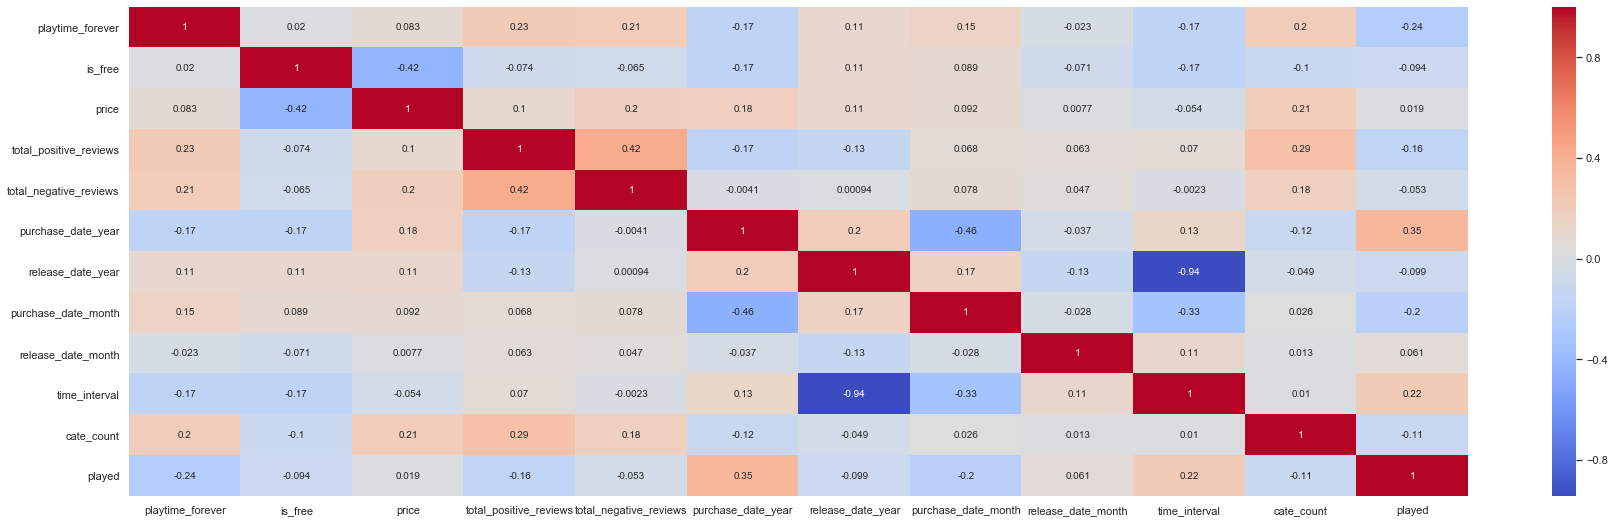

In [12]:
plot_heat_map(game_info.loc[:, num_info].corr())

In [13]:
pd.options.display.max_rows = 4000

cate_dataset = pd.get_dummies(game_info['all_cate'].apply(pd.Series).stack()).sum(level=0)
playtime = game_info['playtime_forever']
cate_time = pd.concat([playtime, cate_dataset], axis=1)

test_cate_set = get_cate_type_data(game_info[train_len:], 'all_cate')
train_cate_set = get_cate_type_data(game_info[:train_len], 'all_cate')
cate_list = list(test_cate_set.intersection(train_cate_set))
cate_time = cate_time[['playtime_forever'] + list(cate_list)]


In [14]:
time_corr = cate_time.corr().loc['playtime_forever', :]
high_corr_tags = list(time_corr[np.abs(time_corr.values) > 0.2 ].drop('playtime_forever').index)

num_game = count_cate_game(cate_time).drop('playtime_forever')
mid_range_tags = list(num_game[(num_game.values < 200) & (num_game.values > 50)].sort_values().index)

In [15]:
chosen_tags1 = list(set(high_corr_tags).union(set(mid_range_tags)))
#chosen_tags1 = mid_range_tags
cate_time = cate_time.loc[:, ['playtime_forever']+ chosen_tags1]
cate_time.head()


,playtime_forever,onlinecoop,partialcontrollersupport,firstperson,steamleaderboards,fps,turnbasedcombat,rpg,difficult,storyrich,...,turnbasedtactics,turnbased,openworld,casual,coop,gore,steamworkshop,fantasy,masterpiece,thirdperson
0,0.000000,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0.016667,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,1.533333,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1
4,22.333333,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1


In [16]:
#temp = cate_time.sort_values(by='playtime_forever', ascending=False).drop(columns=['playtime_forever'])[:40]
temp = cate_time.sort_values(by='playtime_forever').drop(columns=['playtime_forever'])[0:20]
#temp = cate_time.sort_values(by='playtime_forever')[159:199]
cols = temp.columns
bt = temp.apply(lambda x: x > 0)
top20 = bt.apply(lambda x: list(cols[x.values]), axis=1)

In [17]:
def create_new_group(feature, threshold=0.3):
    '''
    group similar categories
    '''
    corr = cate_time.corr().loc[feature, :].sort_values(ascending=False)
    group = list(corr[corr.values > threshold].index)
    
    if 'playtime_forever' in group:
        group.remove('playtime_forever')
    
    return group

In [18]:
rpg = create_new_group('rpg', threshold=0.2)
rpg.remove('turnbased')
turnbase = create_new_group('turnbasedcombat', threshold=0.4)
multiplayer = create_new_group('multiplayer', 0.4)
strategy = ['simulation', 'strategy', 'steamworkshop']
rpg_controller = rpg + ['fullcontrollersupport']
multiplayer_strategy = list(set(multiplayer + strategy))
puzzle = ['puzzle', 'pointclick']

In [19]:
#rpg_controller
turnbase

['turnbasedcombat', 'turnbasedtactics', 'turnbased']

In [20]:
def create_new_cate(all_cate_list, new_feature, intersection=1):
    if len(set(all_cate_list).intersection(set(new_feature))) >= intersection:
        return 1.0
    else:
        return 0.0

In [21]:
# game_info['is_addictive'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, addictive))
# game_info['is_multiplayer'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer))
#game_info['is_remote'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, remote))
game_info['rpg_controller'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, rpg_controller, intersection=3))
#game_info['multiplayer_strategy'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer_strategy, intersection=len(multiplayer_strategy)))
game_info['is_turnbase'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, turnbase))
#game_info['is_puzzle'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, puzzle, 2))
#game_info['is_multiplayer'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer))
#game_info['is_strategy'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, strategy))
game_info['multiplayer_strategy'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer_strategy))

game_per_month = game_info.loc[:, ['played', 'purchase_date_month']].groupby('purchase_date_month').sum()
playtime_per_month = game_info.loc[:, ['playtime_forever', 'purchase_date_month']].groupby('purchase_date_month').sum()
time = pd.concat([game_per_month, playtime_per_month], axis=1)
time['average'] = time['playtime_forever'] / time['played']
time.sort_values(by='average')

,played,playtime_forever,average
purchase_date_month,,,
8,9.0,1.883333,0.209259
4,21.0,19.833333,0.944444
5,10.0,9.766667,0.976667
6,30.0,33.133333,1.104444
7,15.0,21.300000,1.420000
2,12.0,18.950000,1.579167
1,9.0,17.700000,1.966667
3,16.0,77.850000,4.865625
9,8.0,41.733333,5.216667


In [22]:
temp_df = game_info.loc[:, ['playtime_forever', 'multiplayer_strategy', 'rpg_controller', 'is_turnbase']]
temp_df.corr()

,playtime_forever,multiplayer_strategy,rpg_controller,is_turnbase
playtime_forever,1.000000,0.100645,0.242234,0.204625
multiplayer_strategy,0.100645,1.000000,0.279887,0.179504
rpg_controller,0.242234,0.279887,1.000000,0.221007
is_turnbase,0.204625,0.179504,0.221007,1.000000


In [23]:
cate_features = ['puzzle']

In [24]:
droplist = ['is_free', 'genres', 'categories', 'tags', 'total_negative_reviews', 'purchase_date_year',
           'release_date_year', 'release_date_month', 'played', 'all_cate', 'price']

#game_data = pd.concat([game_info.drop(columns=droplist), cate_time.loc[:, cate_features]], axis=1)
#game_data = pd.concat([game_info.drop(columns=droplist), cate_time], axis=1)
game_data = game_info.drop(columns=droplist)
game_data.head()

,playtime_forever,total_positive_reviews,purchase_date_month,time_interval,cate_count,rpg_controller,is_turnbase,multiplayer_strategy
0,0.000000,372.0,7,5,15,0.0,0.0,0.0
1,0.016667,23.0,11,1,7,0.0,0.0,0.0
2,0.000000,3018.0,7,4,23,0.0,0.0,0.0
3,1.533333,63078.0,11,6,23,1.0,0.0,1.0
4,22.333333,8841.0,3,6,25,1.0,0.0,1.0


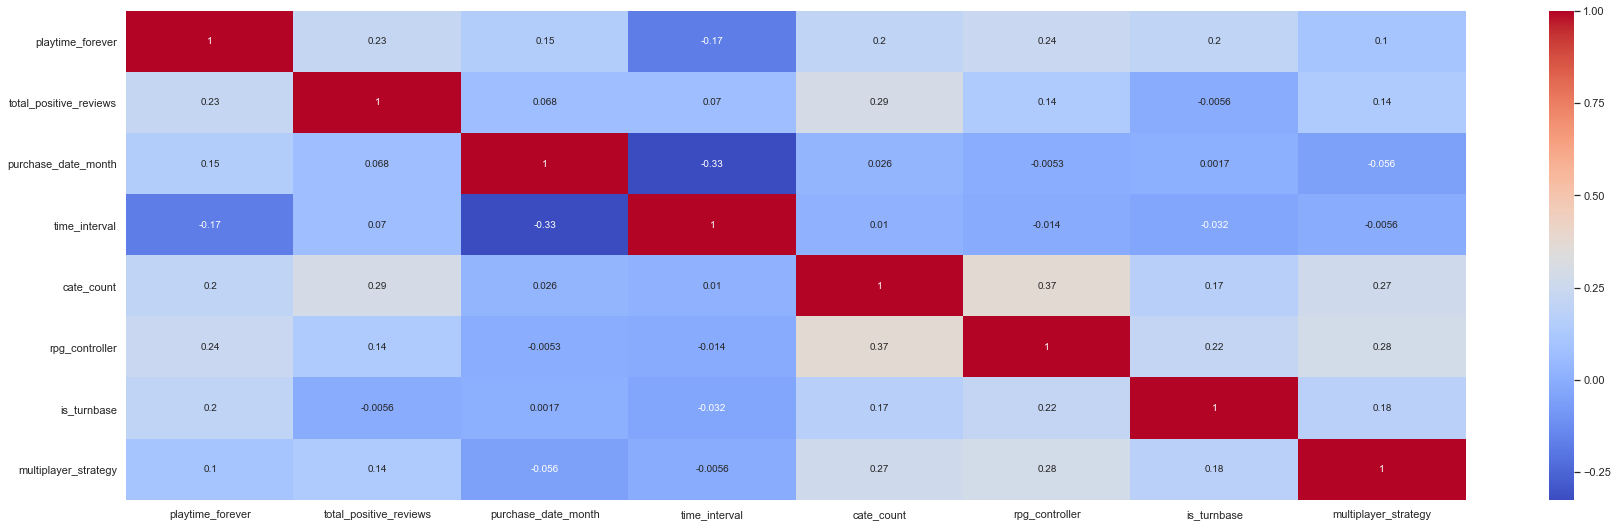

In [25]:
plot_heat_map(game_data.corr())

# Modeling

In [26]:
from sklearn import datasets, linear_model

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [27]:
train_data = game_data[:train_len]
test_data = game_data[train_len:]

train_label = train_data['playtime_forever']
train_data = train_data.drop(columns=['playtime_forever'])
test_data.drop(columns=['playtime_forever'],inplace=True)


print('train_data shape: ', train_data.shape)
print('train_label shape: ', train_label.shape)
print('test_data shape : ', test_data.shape)

train_data.head()

train_data shape:  (324, 7)
train_label shape:  (324,)
test_data shape :  (90, 7)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,total_positive_reviews,purchase_date_month,time_interval,cate_count,rpg_controller,is_turnbase,multiplayer_strategy
0,372.0,7,5,15,0.0,0.0,0.0
1,23.0,11,1,7,0.0,0.0,0.0
2,3018.0,7,4,23,0.0,0.0,0.0
3,63078.0,11,6,23,1.0,0.0,1.0
4,8841.0,3,6,25,1.0,0.0,1.0


In [31]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data)
    rmse= np.sqrt(-cross_val_score(model, train_data, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [32]:
KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.0001, fit_intercept=True, normalize=True))
#model_ridge = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)

regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=5)

decisionTree = DecisionTreeRegressor(random_state=0, max_depth = 2)

In [33]:
lasso_score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(lasso_score.mean(), lasso_score.std()))

enet_score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(enet_score.mean(), enet_score.std()))

krr_score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(krr_score.mean(), krr_score.std()))

ridge_score = rmsle_cv(model_ridge)
print("ridge score: {:.4f} ({:.4f})\n" .format(ridge_score.mean(), ridge_score.std()))

randomtree_score = rmsle_cv(regr)
print("Random Tree score: {:.4f} ({:.4f})\n".format(randomtree_score.mean(), randomtree_score.std()))

decision_score = rmsle_cv(decisionTree)
print("decision score: {:.4f} ({:.4f})\n" .format(decision_score.mean(), decision_score.std()))

# gboost_score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(gboost_score.mean(), gboost_score.std()))

xgb_score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(xgb_score.mean(), xgb_score.std()))

lgb_score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(lgb_score.mean(), lgb_score.std()))


Lasso score: 7.0714 (2.2917)

ElasticNet score: 7.0713 (2.2917)

Kernel Ridge score: 5.5593 (1.7825)

ridge score: 7.0714 (2.2913)

Random Tree score: 8.6071 (3.9205)

decision score: 9.0417 (5.6681)



/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 6.0060 (2.2135)

LGBM score: 5.0700 (1.8006)



In [34]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [35]:
averaged_models = AveragingModels(models = (model_xgb, model_lgb, KRR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


 Averaged base models score: 5.0620 (2.0401)



In [36]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.3, random_state=42)



averaged_models.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
KRR.fit(X_train, y_train)
decisionTree.fit(X_train, y_train)

ave_pred = averaged_models.predict(X_val)
rid_pred = model_ridge.predict(X_val)
lgb_pred = model_lgb.predict(X_val)
krr_pred = KRR.predict(X_val)
dt_pred = decisionTree.predict(X_val)


print("LGB Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, lgb_pred)))
print("Average Model Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, ave_pred)))
print("Ridge Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, rid_pred)))
print("KRR Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, krr_pred)))
print("DT Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, dt_pred)))

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


LGB Root Mean squared error:  4.463186461825959
Average Model Root Mean squared error:  4.494282413833403
Ridge Root Mean squared error:  6.434242401652789
KRR Root Mean squared error:  5.090832403835241
DT Root Mean squared error:  6.468069087312977


In [37]:
KRR.fit(train_data, train_label)
krr_test_pred = KRR.predict(test_data)

averaged_models.fit(train_data, train_label)
ave_test_pred = averaged_models.predict(test_data)

model_lgb.fit(train_data, train_label)
lgb_test_pred = averaged_models.predict(test_data)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [38]:
def export_result(y_test_pred, filename):
    result_df = pd.DataFrame(y_test_pred, columns =['playtime_forever']) 
    neg_idx = list(result_df[result_df['playtime_forever'] < 0.1].index)
    
    result_df['playtime_forever'].iloc[neg_idx] = 0.0
    result_df.index.name = 'id'
    result_df.to_csv(filename)
    
    return result_df

In [39]:
result_krr = export_result(krr_test_pred, 'result_krr.csv')
result_ave = export_result(ave_test_pred, 'result_ave.csv')
result_lgb = export_result(lgb_test_pred, 'result_lgb.csv')

In [40]:
result_krr

,playtime_forever
id,
0,0.000000
1,3.984916
2,0.000000
3,5.089544
4,12.537692
5,0.838696
6,0.000000
7,2.820820
8,0.000000


In [41]:
result_ave

,playtime_forever
id,
0,0.000000
1,2.216036
2,0.946858
3,2.196622
4,7.226910
5,0.297406
6,2.166711
7,1.357665
8,0.000000


In [42]:
result_lgb

,playtime_forever
id,
0,0.000000
1,2.216036
2,0.946858
3,2.196622
4,7.226910
5,0.297406
6,2.166711
7,1.357665
8,0.000000
